# Benchmark Dynast's splicing quantification

This notebook will benchmark Dynast's runtime, memory usage and storage usage against those of the [Velocyto](http://velocyto.org/).

In [1]:
import glob
import os
import re
import time

import anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.patches import Patch

plt.style.use('../figures.mplstyle')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Load the data

Load the runtime and memory usage from those recorded using `time`. Storage is calculated by adding the sizes of all the files (exclusing the `time` output).

In [3]:
with open('data/accessions.txt', 'r') as f:
    accessions = [line.strip() for line in f]

def time_to_seconds(t):
    seconds = 0
    for i, value in enumerate(t.split(':')[::-1]):
        seconds += float(value) * (60 ** i)
    return seconds

def parse_time(out):
    groups = re.search(
        'Elapsed \(wall clock\) time \(h:mm:ss or m:ss\): (?P<runtime>[0-9:\.]+)'
        '.*?'
        'Maximum resident set size \(kbytes\): (?P<memory>[0-9]+)',
        out, re.DOTALL
    ).groupdict()
    return time_to_seconds(groups['runtime']), int(groups['memory']) * 1024

def read_results(out_dir, pipeline):
    print(out_dir, end='...')
    
    try:
        # NOTE: step can contain suffixes of the form _1, _2, ...
        step = os.path.basename(out_dir)
        search = re.search('_[0-9]+', step)
        if search:
            step = step[:search.start()]

        time_path = f'{out_dir}/time.txt'

        with open(time_path, 'r') as f:
            runtime, memory = parse_time(f.read())

        # Find path, exclusing time.txt
        storage = 0
        for dirpath, dirnames, filenames in os.walk(out_dir):
            if '.ipynb_checkpoints' in dirpath:
                continue
            for filename in filenames:
                if filename == 'time.txt':
                    continue
                path = os.path.join(dirpath, filename)
                storage += os.path.getsize(path)
                
        print('OK')
        return {
            'pipeline': pipeline,
            'accession': accession,
            'step': step,
            'runtime': runtime,
            'memory': memory,
            'storage': storage
        }
    except Exception as e:
        print(e)

# runtime in seconds
# memory in bytes
# storage in bytes
results = pd.DataFrame(columns=['pipeline', 'accession', 'step', 'runtime', 'memory', 'storage'])

# Dynast
for accession in accessions:
    for out_dir in sorted(glob.glob(f'dynast/{accession}/*')):
        # Alignment is shared
        if out_dir.endswith('align'):
            continue
        res = read_results(out_dir, 'dynast')
        if res:
            results.loc[len(results)] = res

# Velocyto
for accession in accessions:
    for out_dir in sorted(glob.glob(f'velocyto/{accession}/*')):
        res = read_results(out_dir, 'velocyto')
        if res:
            results.loc[len(results)] = res
            
results.to_csv('data/benchmark.csv', index=False)

dynast/SRR6470906/count...OK
dynast/SRR6470907/count...OK
velocyto/SRR6470906/run...OK
velocyto/SRR6470907/run...OK


In [4]:
accession_names = {
    'SRR6470906': '10X_17_029',
    'SRR6470907': '10X_17_028',
}

## Comparisons

Compare the two pipelines.

### Runtime

Compare the runtimes for each step and accession.

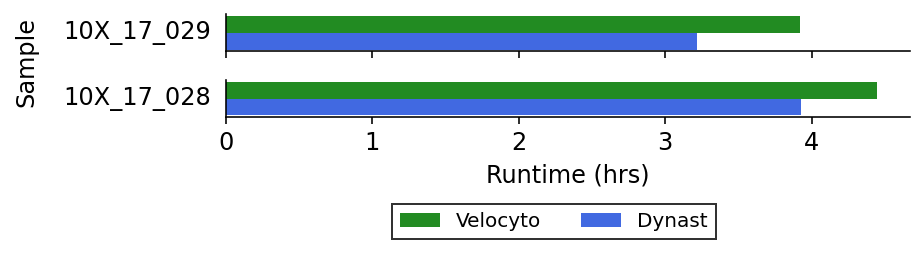

In [93]:
def plot_stacked_runtimes(results, label, i, order, width, ax, **kwargs):
    results = results[results['step'].isin(order)].copy()
    results['step'] = results['step'].astype(
        pd.CategoricalDtype(categories=order, ordered=True)
    )
    results['runtime'] = results['runtime'] / 3600
    
    min_runtime = 0
    max_runtime = 0
    
    height = 0
    for step, part in results.groupby('step'):
        min_runtime += part['runtime'].min()
        max_runtime += part['runtime'].max()
        
        mean = np.mean(part['runtime'])
        if step == order[-1]:
            err_low = (height + mean) - min_runtime
            err_high = max_runtime - (height + mean)
            ax.barh([label], [mean], width, xerr=[[err_low],[err_high]], left=[height], label=label, **kwargs)
        else:
            ax.barh([label], [mean], width, left=[height], label=label, **kwargs)
        
        # jitter = (np.random.random(part.shape[0]) * width) / 4
        # ax.scatter(part['runtime'] + height, jitter + i, zorder=10, color='gray', alpha=0.8, s=5)
        height += mean

fig, axes = plt.subplots(figsize=(6.5, len(accessions) * 0.75), nrows=len(accessions), sharex=True, tight_layout=True)

for ax, accession in zip(axes, accessions):
    accession_results = results[results['accession'] == accession]
    dynast_results = accession_results[(accession_results['pipeline'] == 'dynast')]
    velocyto_results = accession_results[(accession_results['pipeline'] == 'velocyto')]
    
    plot_stacked_runtimes(
        velocyto_results, 'Velocyto', 0, ['run'], 1, ax, color='forestgreen'
    )
    plot_stacked_runtimes(
        dynast_results, 'Dynast', 1, ['count'], 1, ax, color='royalblue'
    )
    
    ylabel = accession_names[accession]
    ax.set_ylabel(ylabel, rotation=0, ha='right', va='center')
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.invert_yaxis()
axes[-1].set_xlabel('Runtime (hrs)')
# axes[0].legend()
fig.legend(handles=[
    Patch(facecolor='forestgreen', label='Velocyto'),
    Patch(facecolor='royalblue', label='Dynast'),
], ncol=2, bbox_to_anchor=(0.78, 0.07))
fig.supylabel('Sample', y=0.68)
fig.savefig('figures/velocyto_runtime.pdf', bbox_inches='tight')
fig.savefig('figures/velocyto_runtime.png', bbox_inches='tight', dpi=300)

In [53]:
velocyto_runtimes = results[results['pipeline'] == 'velocyto'].groupby('accession')['runtime'].sum()
dynast_runtimes = results[results['pipeline'] == 'dynast'].groupby('accession')['runtime'].sum()

In [54]:
# Percent speedup
speedup = (velocyto_runtimes - dynast_runtimes) / velocyto_runtimes * 100
print(speedup)
print(f'Average speedup: {speedup.mean()}')

accession
SRR6470906    17.939093
SRR6470907    11.809500
Name: runtime, dtype: float64
Average speedup: 14.87429675781415


### Memory

Compare the maximum memory usage for each step and accession.

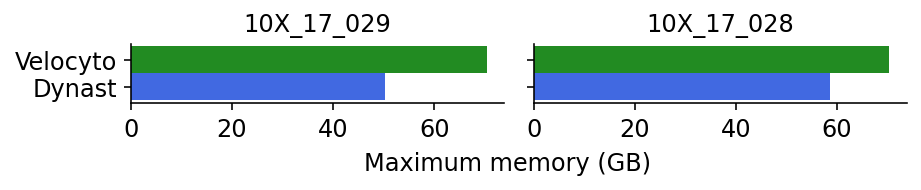

In [94]:
def plot_pipeline_memory(results, order, ax, **kwargs):
    results = results.copy()
    results['step'] = results['step'].astype(
        pd.CategoricalDtype(categories=order, ordered=True)
    )
    results['memory'] = results['memory'] / (1024 ** 3)
    sns.barplot(data=results, y='step', x='memory', ax=ax, saturation=1, **kwargs)
    
fig, axes = plt.subplots(figsize=(6.5, 1.5), ncols=2, tight_layout=True)
for i, accession in enumerate(accessions):
    accession_results = results[results['accession'] == accession]
    dynast_results = accession_results[(accession_results['pipeline'] == 'dynast')]
    velocyto_results = accession_results[(accession_results['pipeline'] == 'velocyto')]
    
    axes[i].barh(
        ['Velocyto'], [velocyto_results['memory'].mean() / (1024 ** 3)], 1, color='forestgreen'
    )
    axes[i].barh(
        ['Dynast'], [dynast_results['memory'].mean() / (1024 ** 3)], 1, color='royalblue'
    )
    axes[i].invert_yaxis()
    axes[i].set_title(accession_names[accession])
    
    if i != 0:
        axes[i].set_yticklabels([])
fig.supxlabel('Maximum memory (GB)', y=0.15, x=0.55)
fig.savefig('figures/velocyto_memory.pdf', bbox_inches='tight')
fig.savefig('figures/velocyto_memory.png', bbox_inches='tight', dpi=300)

In [97]:
velocyto_memory = results[results['pipeline'] == 'velocyto'].groupby('accession')['memory'].sum()
dynast_memory = results[results['pipeline'] == 'dynast'].groupby('accession')['memory'].sum()

In [98]:
# Percent reduction
reduction = (velocyto_memory - dynast_memory) / velocyto_memory * 100
print(reduction)
print(f'Average reduction: {reduction.mean()}')

accession
SRR6470906    28.473362
SRR6470907    16.792693
Name: memory, dtype: float64
Average reduction: 22.63302739723106


### Storage

Compare the size of the output for each step and accession.

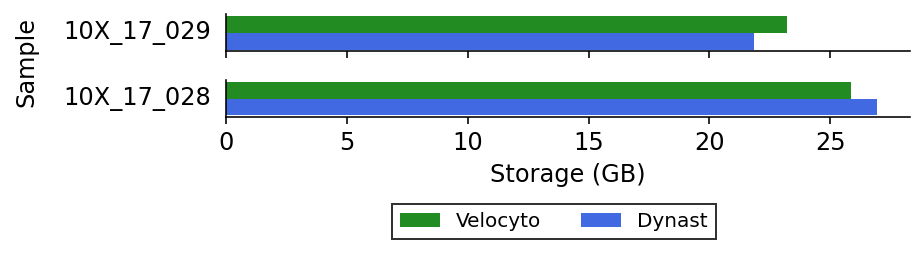

In [95]:
def plot_stacked_storage(results, label, i, order, width, ax, **kwargs):
    results = results[results['step'].isin(order)].copy()
    results['step'] = results['step'].astype(
        pd.CategoricalDtype(categories=order, ordered=True)
    )
    results['storage'] = results['storage'] / (1024 ** 3)
    
    height = 0
    for step, part in results.groupby('step'):
        mean = np.mean(part['storage'])
        ax.barh([label], [mean], width, left=[height], label=label, **kwargs)
        height += mean

fig, axes = plt.subplots(figsize=(6.5, len(accessions) * 0.75), nrows=len(accessions), sharex=True, tight_layout=True)

for ax, accession in zip(axes, accessions):
    accession_results = results[results['accession'] == accession]
    dynast_results = accession_results[(accession_results['pipeline'] == 'dynast')]
    velocyto_results = accession_results[(accession_results['pipeline'] == 'velocyto')]

    plot_stacked_storage(
        velocyto_results, 'Velocyto', 0, ['run'], 1, ax, color='forestgreen'
    )
    plot_stacked_storage(
        dynast_results, 'Dynast', 1, ['count'], 1, ax,  color='royalblue'
    )
    
    ylabel = accession_names[accession]
    ax.set_ylabel(ylabel, rotation=0, ha='right', va='center')
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.invert_yaxis()
axes[-1].set_xlabel('Storage (GB)')
# axes[0].legend()
fig.legend(handles=[
    Patch(facecolor='forestgreen', label='Velocyto'),
    Patch(facecolor='royalblue', label='Dynast'),
], ncol=2, bbox_to_anchor=(0.78, 0.07))
fig.supylabel('Sample', y=0.68)
fig.savefig('figures/velocyto_storage.pdf', bbox_inches='tight')
fig.savefig('figures/velocyto_storage.png', bbox_inches='tight', dpi=300)

In [771]:
scNT_storage = results[results['pipeline'] == 'scNT'].groupby('accession')['storage'].sum()
dynast_storage = results[
    (results['pipeline'] == 'dynast') & (~results['step'].str.endswith('_filter'))
].groupby('accession')['storage'].sum()
dynast_filter_storage = results[
    (results['pipeline'] == 'dynast') & ((results['step'].str.endswith('_filter')) | (results['step'] == 'align'))
].groupby('accession')['storage'].sum()

In [772]:
# Percent saved
storage = (scNT_storage - dynast_storage) / scNT_storage * 100
print(storage)
print(f'Average space improvement: {storage.mean()}')

accession
SRR11683967    93.209408
SRR11683968    93.317690
SRR11683969    93.655140
SRR11683970    93.234820
SRR11683971    91.942556
SRR12225122    94.671968
Name: storage, dtype: float64
Average space improvement: 93.3385969921186


In [773]:
# Percent saved (filter)
storage = (scNT_storage - dynast_filter_storage) / scNT_storage * 100
print(storage)
print(f'Average space improvement: {storage.mean()}')

accession
SRR11683967    95.127242
SRR11683968    95.057447
SRR11683969    95.520749
SRR11683970    94.894665
SRR11683971    94.340874
SRR12225122    95.420638
Name: storage, dtype: float64
Average space improvement: 95.06026895667553
